# Amortization Example in Pandas

Code to support article at [Practical Business Python](http://pbpython.com/amortization-model.html)

Setup the imports and matplotlib plotting

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import matplotlib

In [2]:
%matplotlib inline

In [3]:
matplotlib.style.use('ggplot')

Define a function to build an amortization table/schedule and return the value as a pandas DataFrame

In [4]:
def amortization_table(interest_rate, years, payments_year, principal, addl_principal=0, start_date=date.today()):
    """ Calculate the amortization schedule given the loan details
    
     Args:
        interest_rate: The annual interest rate for this loan
        years: Number of years for the loan
        payments_year: Number of payments in a year
        principal: Amount borrowed
        addl_principal (optional): Additional payments to be made each period. Assume 0 if nothing provided.
                                   must be a value less then 0, the function will convert a positive value to
                                   negative
        start_date (optional): Start date. Will start on first of next month if none provided

    Returns:
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    # Ensure the additional payments are negative
    if addl_principal > 0:
        addl_principal = -addl_principal
    
    # Create an index of the payment dates
    rng = pd.date_range(start_date, periods=years * payments_year, freq='MS')
    rng.name = "Payment_Date"
    
    # Build up the Amortization schedule as a DataFrame
    df = pd.DataFrame(index=rng,columns=['Payment', 'Principal', 'Interest', 
                                         'Addl_Principal', 'Curr_Balance'], dtype='float')
    
    # Add index by period (start at 1 not 0)
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"
    
    # Calculate the payment, principal and interests amounts using built in Numpy functions
    per_payment = np.pmt(interest_rate/payments_year, years*payments_year, principal)
    df["Payment"] = per_payment
    df["Principal"] = np.ppmt(interest_rate/payments_year, df.index, years*payments_year, principal)
    df["Interest"] = np.ipmt(interest_rate/payments_year, df.index, years*payments_year, principal)
        
    # Round the values
    df = df.round(2) 
    
    # Add in the additional principal payments
    df["Addl_Principal"] = addl_principal
    
    # Store the Cumulative Principal Payments and ensure it never gets larger than the original principal
    df["Cumulative_Principal"] = (df["Principal"] + df["Addl_Principal"]).cumsum()
    df["Cumulative_Principal"] = df["Cumulative_Principal"].clip(lower=-principal)
    
    # Calculate the current balance for each period
    df["Curr_Balance"] = principal + df["Cumulative_Principal"]
    
    # Determine the last payment date
    try:
        last_payment = df.query("Curr_Balance <= 0")["Curr_Balance"].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()
    
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
        
    # Truncate the data frame if we have additional principal payments:
    if addl_principal != 0:
                
        # Remove the extra payment periods
        df = df.ix[0:last_payment].copy()
        
        # Calculate the principal for the last row
        df.ix[last_payment, "Principal"] = -(df.ix[last_payment-1, "Curr_Balance"])
        
        # Calculate the total payment for the last row
        df.ix[last_payment, "Payment"] = df.ix[last_payment, ["Principal", "Interest"]].sum()
        
        # Zero out the additional principal
        df.ix[last_payment, "Addl_Principal"] = 0
        
    # Get the payment info into a DataFrame in column order
    payment_info = (df[["Payment", "Principal", "Addl_Principal", "Interest"]]
                    .sum().to_frame().T)
       
    # Format the Date DataFrame
    payment_details = pd.DataFrame.from_items([('payoff_date', [last_payment_date]),
                                               ('Interest Rate', [interest_rate]),
                                               ('Number of years', [years])
                                              ])
    # Add a column showing how much we pay each period.
    # Combine addl principal with principal for total payment
    payment_details["Period_Payment"] = round(per_payment, 2) + addl_principal
    
    payment_summary = pd.concat([payment_details, payment_info], axis=1)
    return df, payment_summary
    

## Examples of running the function

In [5]:
schedule1, stats1 = amortization_table(0.05, 30, 12, 100000, addl_principal=0)

C:\Users\fshok\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


Take a look at the start and end of the table as well as the summary stats

In [6]:
schedule1.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Curr_Balance,Cumulative_Principal
Period,,,,,,,
1,2018-12-01,-536.82,-120.15,-416.67,0,99879.85,-120.15
2,2019-01-01,-536.82,-120.66,-416.17,0,99759.19,-240.81
3,2019-02-01,-536.82,-121.16,-415.66,0,99638.03,-361.97
4,2019-03-01,-536.82,-121.66,-415.16,0,99516.37,-483.63
5,2019-04-01,-536.82,-122.17,-414.65,0,99394.20,-605.80


In [7]:
schedule1.tail()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Curr_Balance,Cumulative_Principal
Period,,,,,,,
356,2048-07-01,-536.82,-525.78,-11.05,0,2125.09,-97874.91
357,2048-08-01,-536.82,-527.97,-8.85,0,1597.12,-98402.88
358,2048-09-01,-536.82,-530.17,-6.65,0,1066.95,-98933.05
359,2048-10-01,-536.82,-532.38,-4.45,0,534.57,-99465.43
360,2048-11-01,-536.82,-534.59,-2.23,0,0.00,-100000.00


In [8]:
stats1

,payoff_date,Interest Rate,Number of years,Period_Payment,Payment,Principal,Addl_Principal,Interest
0,11-01-2048,0.05,30,-536.82,-193255.2,-100000.02,0.0,-93255.69


Try running some other scenarios and combining them into a single DataFrame

In [9]:
schedule2, stats2 = amortization_table(0.05, 30, 12, 100000, addl_principal=-200)
schedule3, stats3 = amortization_table(0.04, 15, 12, 100000, addl_principal=0)

C:\Users\fshok\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\fshok\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\fshok\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\fshok\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: 
.ix is deprecated. Please

In [10]:
# Combine all the scenarios into 1 view
pd.concat([stats1, stats2, stats3], ignore_index=True)

,payoff_date,Interest Rate,Number of years,Period_Payment,Payment,Principal,Addl_Principal,Interest
0,11-01-2048,0.05,30,-536.82,-193255.20,-100000.02,0.0,-93255.69
1,04-01-2039,0.05,30,-736.82,-131689.78,-51200.00,-48800.0,-80490.16
2,11-01-2033,0.04,15,-739.69,-133144.20,-100000.03,0.0,-33143.85


In [11]:
schedule3.head()

,Payment_Date,Payment,Principal,Interest,Addl_Principal,Curr_Balance,Cumulative_Principal
Period,,,,,,,
1,2018-12-01,-739.69,-406.35,-333.33,0,99593.65,-406.35
2,2019-01-01,-739.69,-407.71,-331.98,0,99185.94,-814.06
3,2019-02-01,-739.69,-409.07,-330.62,0,98776.87,-1223.13
4,2019-03-01,-739.69,-410.43,-329.26,0,98366.44,-1633.56
5,2019-04-01,-739.69,-411.80,-327.89,0,97954.64,-2045.36


## Examples of plotting the data

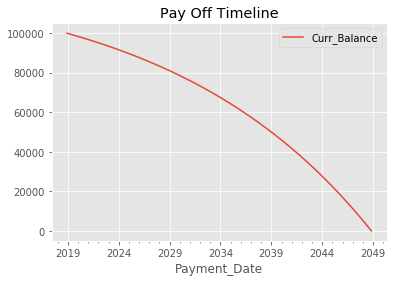

In [12]:
schedule1.plot(x='Payment_Date', y='Curr_Balance', title="Pay Off Timeline");

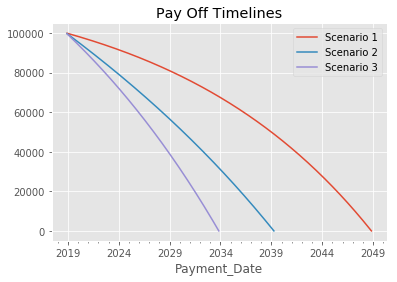

In [13]:
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 2", ax=ax)
schedule3.plot(x='Payment_Date', y='Curr_Balance', label="Scenario 3", ax=ax)
plt.title("Pay Off Timelines");

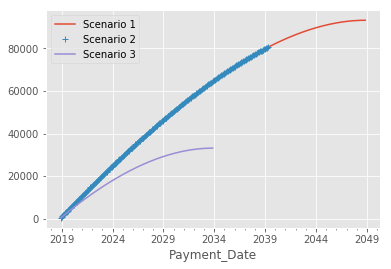

In [14]:
schedule1["Cum_Interest"] = schedule1["Interest"].abs().cumsum()
schedule2["Cum_Interest"] = schedule2["Interest"].abs().cumsum()
schedule3["Cum_Interest"] = schedule3["Interest"].abs().cumsum()

fig, ax = plt.subplots(1, 1)


schedule1.plot(x='Payment_Date', y='Cum_Interest', label="Scenario 1", ax=ax)
schedule2.plot(x='Payment_Date', y='Cum_Interest', label="Scenario 2", ax=ax, style='+')
schedule3.plot(x='Payment_Date', y='Cum_Interest', label="Scenario 3", ax=ax)

ax.legend(loc="best");

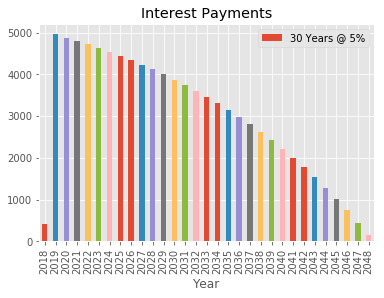

In [15]:
fig, ax = plt.subplots(1, 1)

y1_schedule = schedule1.set_index('Payment_Date').resample("A")["Interest"].sum().abs().reset_index()
y1_schedule["Year"] = y1_schedule["Payment_Date"].dt.year
y1_schedule.plot(kind="bar", x="Year", y="Interest", ax=ax, label="30 Years @ 5%")

plt.title("Interest Payments");